 Fase de ETL y Modelado

In [64]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
from datetime import datetime


In [65]:
# Carga de datasets 
df_pacientes = pd.read_csv("pacientes_salud_mental.csv")
df_diagnosticos = pd.read_csv("diagnosticos.csv")
df_internaciones = pd.read_csv("internaciones.csv")


En primer lugar, se procedió a la importación de las librerías esenciales para el procesamiento y análisis de datos: pandas para la manipulación de estructuras tabulares, numpy para operaciones numéricas, y datetime para el tratamiento de variables temporales. A continuación, se efectuó la carga de las tres fuentes principales de información: la base de pacientes del sistema de salud mental, los diagnósticos registrados y las internaciones realizadas. Esta segmentación responde a una lógica de organización estructurada que permite, en etapas posteriores, la vinculación entre registros y la generación de nuevas variables derivadas, conforme a los objetivos del análisis.

In [66]:
# Ver columnas disponibles en cada dataset
print("Columnas de PACIENTES:")
print(df_pacientes.columns)

print("\nColumnas de DIAGNÓSTICOS:")
print(df_diagnosticos.columns)

print("\nColumnas de INTERNACIONES:")
print(df_internaciones.columns)


Columnas de PACIENTES:
Index(['paciente_nro', 'paciente_fecha_nacimiento', 'paciente_sexo',
       'paciente_lat', 'paciente_long', 'paciente_barrio',
       'paciente_area_referencia', 'origen_dato', 'paciente_localidad',
       'paciente_provincia'],
      dtype='object')

Columnas de DIAGNÓSTICOS:
Index(['nro_paciente', 'fecha_carga_diagnostico', 'codigo_cie_10',
       'descripcion_cie_10', 'diagnostico_manual', 'codigo_subjetivo',
       'descripcion_subjetivo', 'diagnostico_manual_subjetivo', 'subjetivo',
       'objetivo', 'problema', 'plan', 'obra_social', 'centro_atencion',
       'nombre_localidad', 'especialidad', 'servicio', 'paciente_edad_actual',
       'diagnostico_edad'],
      dtype='object')

Columnas de INTERNACIONES:
Index(['paciente_nro', 'nombre_centro', 'nombre_localidad', 'servicio',
       'fecha_ingreso', 'fecha_egreso', 'dias_total_estada',
       'especialidad_solicitante', 'fecha_ingreso_servicio',
       'fecha_egreso_al_servicio', 'dias_estada', 'especial

A fin de contextualizar el contenido informacional de cada una de las bases disponibles, se realizó una visualización preliminar de las columnas que integran los datasets de pacientes, diagnósticos e internaciones. Este procedimiento permitió detectar, en primer término, la existencia de variables redundantes, posibles claves de unión y datos relevantes para la construcción del modelo. 

In [67]:
# Realizamos el merge con la tabla intermedia de pacientes
df_merged_int = df_internaciones.merge(df_pacientes, on='paciente_nro', how='left')

# Mostramos estructura para verificar
df_merged_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40253 entries, 0 to 40252
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   paciente_nro                         40253 non-null  int64  
 1   nombre_centro                        40253 non-null  object 
 2   nombre_localidad                     40253 non-null  object 
 3   servicio                             40253 non-null  object 
 4   fecha_ingreso                        40253 non-null  object 
 5   fecha_egreso                         40253 non-null  object 
 6   dias_total_estada                    40253 non-null  int64  
 7   especialidad_solicitante             40253 non-null  object 
 8   fecha_ingreso_servicio               40253 non-null  object 
 9   fecha_egreso_al_servicio             40253 non-null  object 
 10  dias_estada                          40253 non-null  int64  
 11  especialidad_actual         

Para incorporar al análisis variables contextuales vinculadas a episodios de internación, se procedió a la unión entre la tabla de internaciones y la estructura intermedia de pacientes, utilizando como clave el identificador único paciente_nro. Esta operación permitirá incorporar información relacionada con motivos de internación, días totales de estadía, especialidades intervinientes y situación laboral, las cuales pueden funcionar como factores explicativos o moderadores del riesgo suicida.

In [68]:
# Agrupamos internaciones por paciente
df_internaciones_agg = df_internaciones.groupby('paciente_nro').agg({
    'dias_total_estada': 'mean',
    'tipo_egreso': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Desconocido',
    'especialidad_actual': lambda x: any('MENTAL' in str(i).upper() for i in x)
}).reset_index()

# Renombramos columnas para mayor claridad
df_internaciones_agg.rename(columns={
    'dias_total_estada': 'dias_estada_avg',
    'tipo_egreso': 'tipo_egreso_mas_frecuente',
    'especialidad_actual': 'internacion_salud_mental'
}, inplace=True)

# Agregamos la cantidad de internaciones
conteo = df_internaciones['paciente_nro'].value_counts().rename('n_internaciones').reset_index()
conteo.columns = ['paciente_nro', 'n_internaciones']

# Combinamos con el agregado anterior
df_internaciones_agg = df_internaciones_agg.merge(conteo, on='paciente_nro', how='left')

df_internaciones_agg.head(10)



,paciente_nro,dias_estada_avg,tipo_egreso_mas_frecuente,internacion_salud_mental,n_internaciones
0,1411,1.388060,EGRESO POR ORDEN MEDICA,False,67
1,1960,6.250000,ALTA,False,4
2,4632,2.333333,EGRESO POR ORDEN MEDICA,False,3
3,5316,2.000000,DEFUNCION,False,1
4,6209,5.500000,EGRESO POR DEFUNCION,False,4
5,6316,10.400000,ALTA,False,5
6,6517,1.000000,ALTA,False,2
7,6667,15.000000,ALTA,False,2
8,6796,5.000000,DEFUNCION,False,1
9,6823,14.000000,EGRESO POR ORDEN MEDICA,False,3


Con el propósito de enriquecer el dataset con información derivada de las trayectorias asistenciales, se elaboraron variables agregadas a partir del dataset de internaciones. Estas incluyen: la cantidad total de internaciones por paciente (n_internaciones), el promedio de días de estadía (dias_estada_avg), el tipo de egreso más frecuente (tipo_egreso_mas_frecuente) y una variable indicadora (internacion_salud_mental) que marca si el paciente fue internado alguna vez bajo una especialidad vinculada a salud mental. Estas características permiten identificar perfiles clínicos más complejos o crónicos, relevantes para la predicción del riesgo suicida.

In [69]:
import unicodedata

# Función para normalizar texto: pasa a minúsculas, remueve tildes y caracteres raros
def normalizar_texto(texto):
    if isinstance(texto, str):
        texto = texto.lower()
        texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8')
        return texto
    return ""

# Lista de palabras clave asociadas a riesgo suicida
palabras_clave = ['suicidio', 'intento', 'ideacion', 'autolesion', 'no quiere vivir']

# Normalizamos el campo 'subjetivo'
df_diagnosticos['subjetivo_normalizado'] = df_diagnosticos['subjetivo'].apply(normalizar_texto)

# Creamos la variable binaria de riesgo suicida SOLO si el código CIE-10 comienza con F
def marcar_riesgo_f(row):
    texto = row['subjetivo_normalizado']
    cie = row['codigo_cie_10']
    if isinstance(texto, str) and isinstance(cie, str) and cie.startswith('F'):
        return int(any(palabra in texto for palabra in palabras_clave))
    return 0

df_diagnosticos['riesgo_suicida'] = df_diagnosticos.apply(marcar_riesgo_f, axis=1)

# Agrupamos por paciente y generamos resumen
df_diag_agg = df_diagnosticos.groupby('nro_paciente').agg({
    'riesgo_suicida': 'max',
    'codigo_cie_10': 'count'
}).rename(columns={
    'codigo_cie_10': 'n_diagnosticos'
}).reset_index()

# Vista previa
print(df_diag_agg.head())

# Totales
print("Total pacientes con riesgo suicida:", df_diag_agg['riesgo_suicida'].sum())


   nro_paciente  riesgo_suicida  n_diagnosticos
0          9599               0               2
1          9767               0               4
2         19231               0               1
3         21992               0               1
4         23219               0              15
Total pacientes con riesgo suicida: 1121


Con el propósito de incorporar al dataset información clínica relevante vinculada a los motivos de consulta, se construyeron variables agregadas a partir del dataset de diagnósticos. En particular, se diseñó una variable indicadora de riesgo suicida (`riesgo_suicida`) que se activa únicamente cuando coexisten dos condiciones: la presencia de expresiones clave en el campo subjetivo (como “suicidio”, “autolesión”, “no quiere vivir”) y la asociación con un código CIE-10 perteneciente al bloque F, correspondiente a trastornos mentales y del comportamiento.

Dado que el campo `subjetivo` se encuentra en lenguaje natural y sin control de formato, fue necesario aplicar una etapa previa de normalización (conversión a minúsculas, remoción de tildes y caracteres especiales). En contraste, el campo `codigo_cie_10` no requiere transformaciones por tratarse de un sistema estandarizado.

Además, se construyó una variable adicional (`n_diagnosticos`) que cuantifica el total de diagnósticos registrados por paciente, lo que puede reflejar continuidad en la atención o mayor complejidad clínica. Ambas variables contribuyen a robustecer la matriz de entrenamiento, aportando información sensible a la detección de poblaciones en riesgo.


In [70]:
import unicodedata

# Función de normalización del texto
def normalizar_texto(texto):
    if isinstance(texto, str):
        texto = texto.lower()
        texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8')
        return texto
    return ""

# Aplicar normalización al campo subjetivo
df_diagnosticos["subjetivo_normalizado"] = df_diagnosticos["subjetivo"].apply(normalizar_texto)

# Crear columnas binarias por síntoma
df_diagnosticos["refiere_ansiedad"] = df_diagnosticos["subjetivo_normalizado"].str.contains("ansiedad").astype(int)
df_diagnosticos["refiere_estres"] = df_diagnosticos["subjetivo_normalizado"].str.contains("estres").astype(int)
df_diagnosticos["refiere_insomnio"] = df_diagnosticos["subjetivo_normalizado"].str.contains("insomnio").astype(int)

# Agrupar por paciente y consolidar en columnas finales
df_subjetivas_agg = df_diagnosticos.groupby("nro_paciente")[["refiere_ansiedad", "refiere_estres", "refiere_insomnio"]].max().reset_index()

# Vista previa
df_subjetivas_agg.head()


,nro_paciente,refiere_ansiedad,refiere_estres,refiere_insomnio
0,9599,0,0,0
1,9767,0,0,0
2,19231,0,0,0
3,21992,0,0,0
4,23219,0,0,0


Con el propósito de incorporar al dataset información clínica subjetiva vinculada a los motivos de consulta, se elaboraron variables agregadas a partir del campo libre subjetivo contenido en el dataset de diagnósticos. En primer lugar, se aplicó una etapa de normalización del texto —conversión a minúsculas, remoción de tildes y caracteres especiales— con el objetivo de facilitar la detección de palabras clave en lenguaje natural, habitualmente registradas sin control de formato ni estandarización.

A continuación, se identificó la presencia de los términos “ansiedad”, “estrés” e “insomnio” dentro del contenido textual normalizado, sin considerar su posición ni la cantidad de apariciones. Esta operación permitió construir, mediante agrupamiento por número de paciente (nro_paciente), tres variables indicadoras:

refiere_ansiedad: toma valor 1 si el paciente refirió ansiedad en al menos una consulta;

refiere_estres: toma valor 1 si manifestó estrés;

refiere_insomnio: toma valor 1 si mencionó insomnio.

Estas variables permiten capturar manifestaciones clínicas subjetivas que, si bien no siempre constituyen un diagnóstico formal, pueden representar signos tempranos o persistentes de sufrimiento emocional, contribuyendo a enriquecer la matriz de entrenamiento con información sensible al análisis del riesgo suicida.



In [71]:
# Ver primeros valores únicos tal como están
df_diagnosticos["obra_social"].value_counts(dropna=False).head(20)


obra_social
PROGRAMA SUMAR                                                                238443
OSEF - OSPTF -  OBRA SOCIAL DE LA PROV DE TIERRA DEL FUEGO                     72718
OSPTF - OBRA SOCIAL DE LA PROVINCIA DE TIERRA DEL FUEGO                        60732
PARTICULARES ARGENTINOS                                                        16157
SIN IDENTIFICAR                                                                16020
SIN COBERTURA                                                                  11354
OSUTHGRA- O.S. UNION TRAB. HOTELEROS Y GASTRONOMICOS DE LA REP. ARG.            8787
O.S.E.C.A.C-OBRA SOCIAL DE LOS EMPLEADOS DE COMERCIO Y ACTIVIDADES CIVILES      8639
UOM -OSUOMRA- OBRA SOCIAL DE LA UNION OBRERA METALUR. DE LA R.A.                8069
OSECAC - OBRA SOCIAL DE EMPLEADOS DE COMERCIO Y ACTIVIDADES CIVILES             7614
UNION PERSONAL- O.S. DE LA UNION DEL PERSONAL CIVIL DE LA NACION                7422
SANCOR SALUD - ASOCIACIÓN MUTUAL SANCOR SALUD        

In [72]:
import unicodedata

# Función de normalización
def normalizar_texto(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    texto = unicodedata.normalize("NFKD", texto).encode("ascii", "ignore").decode("utf-8")
    return texto

# Clasificación robusta de cobertura desde obra_social
def clasificar_cobertura(valor):
    texto = normalizar_texto(valor)

    if any(x in texto for x in ["sumar", "sin identificar", "sin cobertura", "particulares argentinos"]):
        return "SIN COBERTURA"
    elif any(x in texto for x in ["osef", "osptf", "ministerio de salud", "iosfa", "inssjp", "profe", "inst. nac. servicios sociales jubilados"]):
        return "OBRA SOCIAL ESTATAL"
    elif texto != "":
        return "OBRA SOCIAL PAGA"
    else:
        return "SIN DATOS"

# Aplicar clasificación
df_diagnosticos["cobertura_cat"] = df_diagnosticos["obra_social"].apply(clasificar_cobertura)

# Vista de distribución
print(df_diagnosticos["cobertura_cat"].value_counts(dropna=False))


cobertura_cat
SIN COBERTURA          281974
OBRA SOCIAL ESTATAL    146128
OBRA SOCIAL PAGA       101907
SIN DATOS                 257
Name: count, dtype: int64


Con el propósito de incorporar al análisis una variable que refleje el acceso a cobertura sanitaria, se procedió a clasificar las obras sociales registradas en los diagnósticos bajo tres categorías principales. Esta clasificación se realizó a partir del campo obra_social, el cual contiene denominaciones heterogéneas y no estandarizadas.

Para facilitar su análisis, se creó la variable cobertura_cat, definida de la siguiente manera:

SIN COBERTURA: incluye expresiones tales como “programa sumar”, “sin identificar”, “sin cobertura” y “particulares argentinos”, que refieren a situaciones de atención sin intermediación de un financiador formal;

OBRA SOCIAL ESTATAL: comprende a organismos públicos como OSEF, OSPTF, PROFE, IOSFA, INSSJP y otros sistemas de salud dependientes del Estado;

OBRA SOCIAL PAGA: abarca al resto de las entidades, usualmente prestadoras privadas, mutuales o prepagas;

SIN DATOS: se asigna en casos residuales donde la información no se encuentra disponible o legible.

Esta clasificación permite distinguir entre distintos niveles de acceso al sistema de salud y su posible relación con la detección, frecuencia o gravedad de los cuadros atendidos. La incorporación de esta variable busca captar desigualdades estructurales que podrían incidir en la aparición o persistencia de situaciones de riesgo.



In [73]:
# 🔁 Renombramos para unificar claves
df_diag_agg = df_diag_agg.rename(columns={"nro_paciente": "paciente_nro"})
df_subjetivas_agg = df_subjetivas_agg.rename(columns={"nro_paciente": "paciente_nro"})

# ✅ Extraemos edad del primer diagnóstico por paciente (forma directa y segura)
df_edad = df_diagnosticos.groupby("nro_paciente")["diagnostico_edad"].first().reset_index()
df_edad = df_edad.rename(columns={"nro_paciente": "paciente_nro", "diagnostico_edad": "edad"})

# 📎 Incorporamos la edad al resumen de diagnóstico
df_diag_agg = df_diag_agg.merge(df_edad, on="paciente_nro", how="left")

# 🧠 Extraemos variables sociales de la última internación
df_internaciones["fecha_ingreso"] = pd.to_datetime(df_internaciones["fecha_ingreso"], errors='coerce')
df_internaciones_ordenado = df_internaciones.sort_values(by=["paciente_nro", "fecha_ingreso"], ascending=[True, False])
df_sociedad = df_internaciones_ordenado.groupby("paciente_nro").first().reset_index()
df_sociedad = df_sociedad[["paciente_nro", "nivel_estudio", "situacion_laboral_actual", "profesion"]]

# 🧩 Merge progresivo de todas las fuentes

# 1. Pacientes + internaciones agregadas
df_merged = df_pacientes.merge(df_internaciones_agg, on="paciente_nro", how="left")

# 2. + Diagnósticos (incluye riesgo, cantidad y edad)
df_merged = df_merged.merge(df_diag_agg, on="paciente_nro", how="left")

# 3. + Subjetivas
df_merged = df_merged.merge(df_subjetivas_agg, on="paciente_nro", how="left")

# 4. + Sociales
df_merged = df_merged.merge(df_sociedad, on="paciente_nro", how="left")

# 🧹 Limpieza y completado

# Completamos variables binarias
cols_binarias = ["riesgo_suicida", "refiere_ansiedad", "refiere_estres", "refiere_insomnio", "internacion_salud_mental"]
for col in cols_binarias:
    df_merged[col] = df_merged[col].fillna(0).astype(int)

# Completamos variables numéricas
cols_numericas = ["n_diagnosticos", "n_internaciones", "dias_estada_avg"]
for col in cols_numericas:
    df_merged[col] = df_merged[col].fillna(0)

# Completamos variables categóricas
df_merged["tipo_egreso_mas_frecuente"] = df_merged["tipo_egreso_mas_frecuente"].fillna("NO REGISTRA")

# Selección final de columnas
cols_finales = [
    "paciente_nro", "edad", "paciente_sexo", "paciente_localidad", "cobertura_cat",
    "n_internaciones", "dias_estada_avg", "tipo_egreso_mas_frecuente", "internacion_salud_mental",
    "n_diagnosticos", "refiere_ansiedad", "refiere_estres", "refiere_insomnio",
    "nivel_estudio", "situacion_laboral_actual", "profesion",
    "riesgo_suicida"
]

# Asignamos el dataset final consolidado
df_final = df_merged[cols_finales].copy()

# Vista previa
df_final.head()


KeyError: "['cobertura_cat'] not in index"

In [74]:
# Unificamos claves en diagnósticos
df_diagnosticos = df_diagnosticos.rename(columns={"nro_paciente": "paciente_nro"})

# Aseguramos fechas en formato datetime
df_diagnosticos["fecha_carga_diagnostico"] = pd.to_datetime(df_diagnosticos["fecha_carga_diagnostico"], errors='coerce')
df_internaciones["fecha_ingreso"] = pd.to_datetime(df_internaciones["fecha_ingreso"], errors='coerce')
df_pacientes["paciente_fecha_nacimiento"] = pd.to_datetime(df_pacientes["paciente_fecha_nacimiento"], errors='coerce')

# Calculamos edad desde la fecha de nacimiento (año 2024 como referencia fija)
df_edad = df_pacientes[["paciente_nro", "paciente_fecha_nacimiento"]].copy()
df_edad["edad"] = df_edad["paciente_fecha_nacimiento"].apply(
    lambda x: 2024 - x.year if pd.notnull(x) else None
)
df_edad = df_edad[["paciente_nro", "edad"]]

# Variables sociales desde la última internación
df_internaciones_ordenado = df_internaciones.sort_values(by=["paciente_nro", "fecha_ingreso"], ascending=[True, False])
df_sociedad = df_internaciones_ordenado.groupby("paciente_nro").first().reset_index()
df_sociedad = df_sociedad[["paciente_nro", "nivel_estudio", "situacion_laboral_actual", "profesion"]]

# Centro de atención más frecuente por paciente
df_centro = df_diagnosticos.groupby("paciente_nro")["centro_atencion"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
).reset_index()
df_centro = df_centro.rename(columns={"centro_atencion": "centro_atencion_mas_frecuente"})

# Cobertura más frecuente por paciente desde diagnósticos
cobertura_agg = df_diagnosticos.groupby("paciente_nro")["cobertura_cat"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else "SIN DATOS"
).reset_index()

# Renombramos claves en agregados
df_diag_agg = df_diag_agg.rename(columns={"nro_paciente": "paciente_nro"})
df_subjetivas_agg = df_subjetivas_agg.rename(columns={"nro_paciente": "paciente_nro"})

# Consolidación progresiva
df_merged = df_pacientes.merge(df_internaciones_agg, on="paciente_nro", how="left")
df_merged = df_merged.merge(df_diag_agg, on="paciente_nro", how="left")
df_merged = df_merged.merge(df_subjetivas_agg, on="paciente_nro", how="left")
df_merged = df_merged.merge(df_sociedad, on="paciente_nro", how="left")
df_merged = df_merged.merge(df_centro, on="paciente_nro", how="left")
df_merged = df_merged.merge(cobertura_agg, on="paciente_nro", how="left")

# Eliminamos edad previa si existiera y unimos la edad calculada
if "edad" in df_merged.columns:
    df_merged = df_merged.drop(columns=["edad"])
df_merged = df_merged.merge(df_edad, on="paciente_nro", how="left")

# Limpieza de variables
cols_binarias = ["riesgo_suicida", "refiere_ansiedad", "refiere_estres", "refiere_insomnio", "internacion_salud_mental"]
for col in cols_binarias:
    df_merged[col] = df_merged[col].fillna(0).astype(int)

cols_numericas = ["n_diagnosticos", "n_internaciones", "dias_estada_avg"]
for col in cols_numericas:
    df_merged[col] = df_merged[col].fillna(0)

df_merged["tipo_egreso_mas_frecuente"] = df_merged["tipo_egreso_mas_frecuente"].fillna("NO REGISTRA")

# Selección de columnas finales
cols_finales = [
    "paciente_nro", "edad", "paciente_sexo", "paciente_localidad", "paciente_barrio", "cobertura_cat",
    "n_internaciones", "dias_estada_avg", "tipo_egreso_mas_frecuente", "internacion_salud_mental",
    "n_diagnosticos", "refiere_ansiedad", "refiere_estres", "refiere_insomnio",
    "nivel_estudio", "situacion_laboral_actual", "profesion", "centro_atencion_mas_frecuente",
    "riesgo_suicida"
]

df_final = df_merged[cols_finales].copy()

# Filtramos edad entre 12 y 29 años inclusive
df_final["edad"] = pd.to_numeric(df_final["edad"], errors='coerce')
df_final = df_final[df_final["edad"].between(12, 29, inclusive="both")].copy()

# Vista previa del resultado
df_final.head()


,paciente_nro,edad,paciente_sexo,paciente_localidad,paciente_barrio,cobertura_cat,n_internaciones,dias_estada_avg,tipo_egreso_mas_frecuente,internacion_salud_mental,n_diagnosticos,refiere_ansiedad,refiere_estres,refiere_insomnio,nivel_estudio,situacion_laboral_actual,profesion,centro_atencion_mas_frecuente,riesgo_suicida
502,21992,12.0,M,USHUAIA,NaN,SIN COBERTURA,0.0,0.0,NO REGISTRA,0,1.0,0,0,0,NaN,NaN,NaN,HOSPITAL REGIONAL DE USHUAIA,0
623,27291,19.0,M,USHUAIA,NaN,SIN COBERTURA,0.0,0.0,NO REGISTRA,0,3.0,0,0,0,NaN,NaN,NaN,E. A. D. Adolescencia - Dir: Intevu 14 casa 44,0
635,28291,25.0,F,USHUAIA,NaN,SIN COBERTURA,1.0,4.0,ALTA,0,54.0,0,0,0,SECUNDARIO INCOMP.,OPERARIO,None,HOSPITAL REGIONAL DE USHUAIA,0
4769,83168,21.0,F,RIO GRANDE,NaN,NaN,0.0,0.0,NO REGISTRA,0,0.0,0,0,0,NaN,NaN,NaN,NaN,0
4888,84377,20.0,F,USHUAIA,NaN,OBRA SOCIAL PAGA,0.0,0.0,NO REGISTRA,0,1.0,0,0,0,NaN,NaN,NaN,HOSPITAL REGIONAL DE USHUAIA,0


Se unificaron las claves primarias en las distintas fuentes de datos, renombrando los identificadores de paciente a un formato homogéneo (paciente_nro). Se aseguraron los formatos de fecha en las variables relevantes (paciente_fecha_nacimiento, fecha_ingreso y fecha_carga_diagnostico), a fin de evitar inconsistencias durante el procesamiento.

La edad se calculó como diferencia entre el año 2024 y el año de nacimiento registrado, generando una nueva variable numérica (edad) que fue posteriormente incorporada al dataset consolidado.

Se extrajeron, además, variables contextuales desde la última internación registrada por paciente, incluyendo nivel_estudio, situacion_laboral_actual y profesion. Desde la base de diagnósticos se identificó el centro de atención más frecuente (centro_atencion_mas_frecuente) para cada paciente mediante la moda estadística.

Una vez integradas todas las fuentes mediante un esquema de merge progresivo sobre la clave común, se procedió a completar los valores faltantes: las variables binarias fueron rellenadas con ceros y convertidas a tipo entero, mientras que las variables numéricas (n_diagnosticos, n_internaciones, dias_estada_avg) se imputaron con ceros. La variable categórica tipo_egreso_mas_frecuente se completó con el valor neutral "NO REGISTRA".

Finalmente, se seleccionaron las columnas relevantes para el análisis y se almacenaron en el objeto df_final. Se aplicó un filtro para conservar únicamente los registros correspondientes a pacientes de entre 12 y 29 años inclusive.



ETAPA EXPLORACIÓN DE DATOS:
OBJETIVOS:

1.Describir la distribución de variables clave

2.Detectar posibles desequilibrios (ej. clase objetivo, sexo)

3.Observar asociaciones preliminares (ej. cobertura vs riesgo)

4.Guiar decisiones para el modelo posterior

In [75]:
# Estadísticas y estructura general
# Resumen general
df_final.info()

# Estadísticas descriptivas para variables numéricas
df_final.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 10868 entries, 502 to 35126
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   paciente_nro                   10868 non-null  int64  
 1   edad                           10868 non-null  float64
 2   paciente_sexo                  10868 non-null  object 
 3   paciente_localidad             10861 non-null  object 
 4   paciente_barrio                4962 non-null   object 
 5   cobertura_cat                  8726 non-null   object 
 6   n_internaciones                10868 non-null  float64
 7   dias_estada_avg                10868 non-null  float64
 8   tipo_egreso_mas_frecuente      10868 non-null  object 
 9   internacion_salud_mental       10868 non-null  int32  
 10  n_diagnosticos                 10868 non-null  float64
 11  refiere_ansiedad               10868 non-null  int32  
 12  refiere_estres                 10868 non-null  in

,paciente_nro,edad,n_internaciones,dias_estada_avg,internacion_salud_mental,n_diagnosticos,refiere_ansiedad,refiere_estres,refiere_insomnio,riesgo_suicida
count,10868.000000,10868.000000,10868.000000,10868.000000,10868.000000,10868.000000,10868.000000,10868.000000,10868.000000,10868.000000
mean,231244.044350,21.739510,0.962827,1.010432,0.003404,26.635444,0.177678,0.071126,0.046559,0.088977
std,40226.070483,4.984965,4.674113,3.477380,0.058251,37.955028,0.382259,0.257047,0.210701,0.284723
min,21992.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,200942.250000,18.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,219374.000000,22.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000
75%,242665.500000,26.000000,1.000000,1.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000
max,328380.000000,29.000000,253.000000,101.000000,1.000000,733.000000,1.000000,1.000000,1.000000,1.000000


Se realizó un relevamiento inicial del dataset df_final con el objetivo de conocer su estructura general y los valores característicos de sus variables numéricas. La base consolidada contiene 10.868 registros correspondientes a pacientes de entre 12 y 29 años, con edad promedio de 21,7 años y una desviación estándar de aproximadamente 4,9 años.

Entre las variables clínicas, se destacan:

n_diagnosticos: media de 26,6 diagnósticos por paciente, aunque con alta dispersión (máximo de 733);

n_internaciones: media cercana a 1, con un máximo de 253;

dias_estada_avg: duración promedio de internación baja, con valores extremos poco frecuentes;

riesgo_suicida: valor medio de 0,08, lo que indica un fuerte desbalance de clases (alrededor del 8,8 % de los registros se etiquetan como positivos).

Las variables binarias que refieren síntomas subjetivos (refiere_ansiedad, refiere_estres, refiere_insomnio) presentan valores medios muy bajos, lo que confirma su carácter esporádico y su potencial valor discriminante.

Se detectó además un porcentaje considerable de datos faltantes en variables contextuales como nivel_estudio (67% completo), situacion_laboral_actual y profesion, que será necesario considerar al momento de definir estrategias de imputación o selección de atributos.



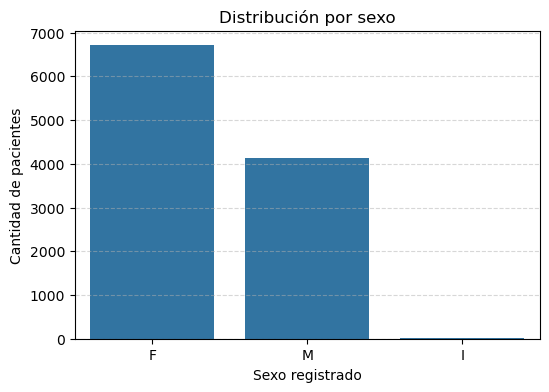

paciente_sexo
F    61.72
M    38.10
I     0.17
Name: proportion, dtype: float64


In [ ]:
#Distribución de pacientes según sexo
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df_final, x="paciente_sexo", order=df_final["paciente_sexo"].value_counts().index)
plt.title("Distribución por sexo")
plt.xlabel("Sexo registrado")
plt.ylabel("Cantidad de pacientes")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

sexo_pct = df_final["paciente_sexo"].value_counts(normalize=True) * 100
print(sexo_pct.round(2))


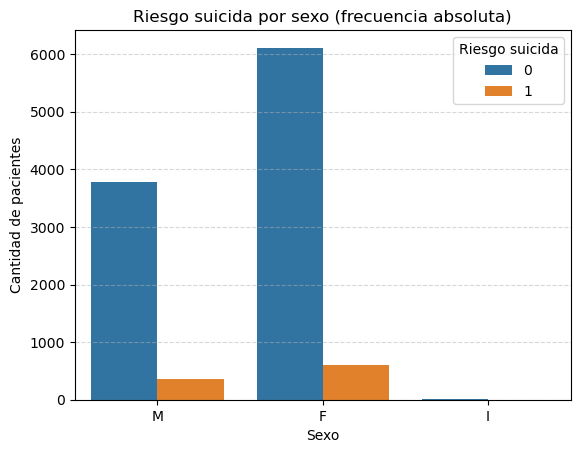

riesgo_suicida      0      1
paciente_sexo               
F               91.10   8.90
I               84.21  15.79
M               91.14   8.86


In [ ]:
# Frecuencia absoluta de riesgo suicida por sexo
sns.countplot(data=df_final, x="paciente_sexo", hue="riesgo_suicida")
plt.title("Riesgo suicida por sexo (frecuencia absoluta)")
plt.xlabel("Sexo")
plt.ylabel("Cantidad de pacientes")
plt.legend(title="Riesgo suicida")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Calculamos proporción de riesgo suicida por sexo
riesgo_por_sexo = pd.crosstab(df_final["paciente_sexo"], df_final["riesgo_suicida"], normalize="index") * 100
print(riesgo_por_sexo.round(2))


Se analizó la variable paciente_sexo con el objetivo de describir la composición general del conjunto de datos y evaluar su relación con la variable objetivo riesgo_suicida. La distribución por sexo evidenció una predominancia de pacientes femeninas, que representan aproximadamente el 61,7 % del total, frente a un 38,1 % de varones y un porcentaje marginal correspondiente a registros autopercibidos bajo la categoría “I”.

Al desagregar los casos según riesgo_suicida, se observó que la mayoría de los registros positivos corresponden a mujeres, lo cual es esperable dado su peso relativo en la muestra. Sin embargo, al analizar la proporción de riesgo dentro de cada grupo, se evidencia que mujeres y varones presentan niveles prácticamente equivalentes (8,90 % y 8,86 %, respectivamente). En contraste, el grupo identificado como "I" presenta una proporción de casos positivos superior (15,79 %), aunque sobre una base de registros considerablemente menor.

Estos resultados permiten concluir que, si bien el sexo registrado no parece ser un factor diferencial en términos proporcionales, sí puede tener incidencia en la cantidad total de casos detectados, debido a su peso dentro del universo de análisis. Se sugiere contemplar esta variable en el modelo como atributo descriptivo, aunque su capacidad predictiva por sí sola podría ser limitada.

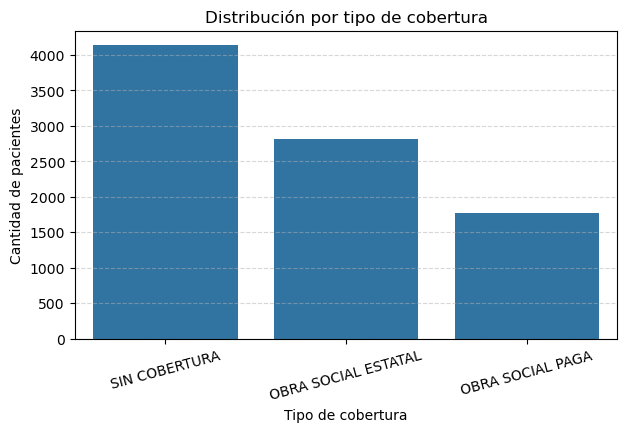

cobertura_cat
SIN COBERTURA          47.40
OBRA SOCIAL ESTATAL    32.23
OBRA SOCIAL PAGA       20.38
Name: proportion, dtype: float64


In [77]:
#Distribución de tipo de cobertura

plt.figure(figsize=(7, 4))
sns.countplot(data=df_final, x="cobertura_cat", order=df_final["cobertura_cat"].value_counts().index)
plt.title("Distribución por tipo de cobertura")
plt.xlabel("Tipo de cobertura")
plt.ylabel("Cantidad de pacientes")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Proporción por cobertura
cobertura_pct = df_final["cobertura_cat"].value_counts(normalize=True) * 100
print(cobertura_pct.round(2))


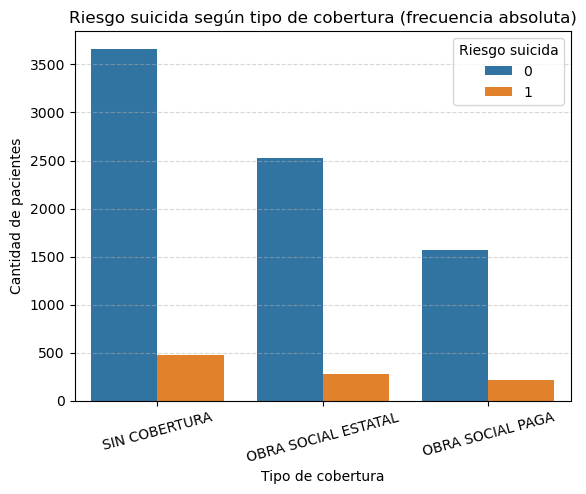

riesgo_suicida           0      1
cobertura_cat                    
OBRA SOCIAL ESTATAL  89.97  10.03
OBRA SOCIAL PAGA     87.96  12.04
SIN COBERTURA        88.61  11.39


In [76]:
sns.countplot(data=df_final, x="cobertura_cat", hue="riesgo_suicida", order=df_final["cobertura_cat"].value_counts().index)
plt.title("Riesgo suicida según tipo de cobertura (frecuencia absoluta)")
plt.xlabel("Tipo de cobertura")
plt.ylabel("Cantidad de pacientes")
plt.legend(title="Riesgo suicida")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Tabla de proporciones
riesgo_por_cobertura = pd.crosstab(df_final["cobertura_cat"], df_final["riesgo_suicida"], normalize="index") * 100
print(riesgo_por_cobertura.round(2))


Se analizó la variable cobertura_cat con el objetivo de describir el acceso a servicios de salud dentro de la población analizada y explorar su eventual relación con el riesgo suicida.

En primer lugar, la distribución general mostró una alta proporción de pacientes sin cobertura formal (47,4 %), seguidos por quienes acceden a servicios estatales (32,2 %) y finalmente aquellos con obra social paga (20,4 %). Esta distribución pone en evidencia la alta dependencia del sistema público y la existencia de sectores sin intermediación financiera en su atención.

Al cruzar esta variable con riesgo_suicida, se observaron proporciones similares entre los tres grupos. La mayor prevalencia relativa se registró entre quienes cuentan con obra social paga (12,04 %), seguida por el grupo sin cobertura (11,39 %) y por quienes acceden al sistema estatal (10,03 %). Si bien las diferencias no son marcadas, podría interpretarse que el tipo de cobertura no constituye, por sí solo, un factor protector directo frente al riesgo suicida.

Estas observaciones refuerzan la importancia de incorporar este atributo al modelo como variable explicativa de contexto, sin asumir una relación lineal directa pero reconociendo su valor estructural en la conformación del perfil asistencial.

In [78]:
# Frecuencia general de síntomas

sintomas = ["refiere_ansiedad", "refiere_estres", "refiere_insomnio"]

for col in sintomas:
    total = df_final[col].sum()
    porcentaje = round(total / len(df_final) * 100, 2)
    print(f"{col}: {total} pacientes ({porcentaje}%)")


refiere_ansiedad: 1931 pacientes (17.77%)
refiere_estres: 773 pacientes (7.11%)
refiere_insomnio: 506 pacientes (4.66%)


In [80]:
#Proporción de riesgo suicida según presencia de síntomas
for col in sintomas:
    print(f"\nRiesgo suicida según presencia de {col}:\n")
    tabla = pd.crosstab(df_final[col], df_final["riesgo_suicida"], normalize="index") * 100
    print(tabla.round(2))



Riesgo suicida según presencia de refiere_ansiedad:

riesgo_suicida        0      1
refiere_ansiedad              
0                 95.38   4.62
1                 71.31  28.69

Riesgo suicida según presencia de refiere_estres:

riesgo_suicida      0      1
refiere_estres              
0               92.29   7.71
1               75.55  24.45

Riesgo suicida según presencia de refiere_insomnio:

riesgo_suicida        0      1
refiere_insomnio              
0                 92.66   7.34
1                 59.29  40.71


Se exploró la relación entre la presencia de síntomas subjetivos referidos por los pacientes en consulta y la variable objetivo riesgo_suicida. Las variables consideradas fueron refiere_ansiedad, refiere_estres y refiere_insomnio, todas de tipo binario.

En términos generales, la presencia de estos síntomas es baja dentro del conjunto de datos:

Ansiedad: 17,8 %

Estrés: 7,1 %

Insomnio: 4,7 %

No obstante, el análisis proporcional revela diferencias sustantivas. Mientras que los pacientes que no refieren estos síntomas presentan proporciones de riesgo suicida cercanas al promedio general (entre 4 % y 7 %), aquellos que sí los manifiestan registran tasas considerablemente más altas:

Ansiedad: 28,7 %

Estrés: 24,5 %

Insomnio: 40,7 %

Este último caso es particularmente destacable, dado que el insomnio, aunque infrecuente, aparece altamente concentrado en pacientes con riesgo identificado. Este hallazgo sugiere que los síntomas subjetivos, aun con baja frecuencia, poseen un fuerte valor predictivo y deberían ser considerados con especial atención durante el entrenamiento del modelo.

In [81]:
#Frecuencia y proporción de riesgo
# Frecuencia general
total_salud_mental = df_final["internacion_salud_mental"].sum()
porcentaje = round(total_salud_mental / len(df_final) * 100, 2)
print(f"Internaciones vinculadas a salud mental: {total_salud_mental} pacientes ({porcentaje}%)")

# Riesgo suicida según presencia de internación en salud mental
riesgo_mental = pd.crosstab(df_final["internacion_salud_mental"], df_final["riesgo_suicida"], normalize="index") * 100
print("\nRiesgo suicida según internación en salud mental:")
print(riesgo_mental.round(2))


Internaciones vinculadas a salud mental: 37 pacientes (0.34%)

Riesgo suicida según internación en salud mental:
riesgo_suicida                0      1
internacion_salud_mental              
0                         91.28   8.72
1                         37.84  62.16


Se examinó la variable internacion_salud_mental, que identifica si el paciente fue alguna vez internado en un servicio vinculado a salud mental, con el objetivo de evaluar su relación con el riesgo suicida.

La frecuencia general de internaciones de este tipo resultó muy baja: apenas 37 pacientes (0,34 %) dentro del conjunto de datos analizado. Este bajo número puede explicarse tanto por la edad de los pacientes como por posibles subregistros en el sistema de atención.

A pesar de su escasa representación, la variable muestra una asociación fuerte con la variable objetivo. Mientras que entre quienes no registraron internaciones vinculadas a salud mental la proporción de riesgo suicida fue del 8,72 %, entre quienes sí las tuvieron la tasa se eleva al 62,16 %.

Este contraste refuerza el valor clínico de la variable como indicador de alta vulnerabilidad, aunque su escaso volumen obliga a considerar estrategias específicas en el modelado para evitar que pierda impacto frente a variables más frecuentes.



In [82]:
#Distribución general por variable

variables_sociales = ["nivel_estudio", "situacion_laboral_actual", "profesion"]

for col in variables_sociales:
    print(f"\nDistribución de {col}:\n")
    print(df_final[col].value_counts(dropna=False).head(10))



Distribución de nivel_estudio:

nivel_estudio
NaN                     7260
SIN ESPECIFICAR         1644
SECUNDARIO               924
SECUNDARIO INCOMP.       370
PRIMARIO                 355
UNIVERSITARIO INCOMP      78
TERCIARIO INCOMPLETO      65
TERCIARIO                 62
NUNCA ASISTIÓ             39
UNIVERSITARIO             36
Name: count, dtype: int64

Distribución de situacion_laboral_actual:

situacion_laboral_actual
NaN                           7260
None                          1960
NO BUSCA TRABAJO               346
AMA DE CASA                    290
ESTUDIANTE                     243
BUSCA TRABAJO                  161
EMPLEADO                       128
TRABAJA O ESTA DE LICENCIA     106
DESEMPLEADO                     81
EMPLEADO ADMINISTRATIVO         62
Name: count, dtype: int64

Distribución de profesion:

profesion
NaN                      7260
None                     3143
Ninguna                   393
NO PROFESIONAL             30
Administración             13
Enf

In [83]:
#Riesgo suicida según categoría (para cada variable)
for col in variables_sociales:
    print(f"\nRiesgo suicida según {col}:\n")
    tabla = pd.crosstab(df_final[col], df_final["riesgo_suicida"], normalize="index") * 100
    print(tabla.round(2).head(10))



Riesgo suicida según nivel_estudio:

riesgo_suicida            0      1
nivel_estudio                     
NUNCA ASISTIÓ         84.62  15.38
PRIMARIO              86.20  13.80
PRIMARIO INCOMPLETO   90.91   9.09
SECUNDARIO            85.82  14.18
SECUNDARIO INCOMP.    79.19  20.81
SIN ESPECIFICAR       84.55  15.45
TERCIARIO             91.94   8.06
TERCIARIO INCOMPLETO  78.46  21.54
UNIVERSITARIO         83.33  16.67
UNIVERSITARIO INCOMP  80.77  19.23

Riesgo suicida según situacion_laboral_actual:

riesgo_suicida                 0      1
situacion_laboral_actual               
AMA DE CASA                90.69   9.31
AUXILIAR                  100.00   0.00
AYUDANTE DE COCINA        100.00   0.00
BUSCA TRABAJO              78.26  21.74
CAJERO                     90.00  10.00
CHANGAS                    80.00  20.00
COCINERO                   62.50  37.50
COSMETOLOGA                50.00  50.00
DESEMPLEADO                76.54  23.46
DOCENTE                    92.86   7.14

Riesgo suici

Se analizó la asociación entre las variables nivel_estudio y situacion_laboral_actual con la presencia de riesgo suicida. Ambos atributos presentaron una alta proporción de valores faltantes (más del 60 % del total), lo cual limita su generalización. No obstante, se identificaron algunos patrones relevantes en los casos con información disponible.

En cuanto al nivel educativo, los pacientes que reportan educación secundaria incompleta registran las tasas más elevadas de riesgo suicida (20,81 %), seguidos por quienes no completaron el nivel universitario (19,23 %) y los que no especificaron su nivel (15,45 %). En cambio, quienes alcanzaron niveles superiores —particularmente terciario o universitario— presentan menores proporciones de riesgo, lo que podría sugerir una relación inversa entre nivel educativo y vulnerabilidad psicosocial.

Respecto a la situación laboral, se observó que el grupo "busca trabajo" es el que presenta el mayor riesgo (21,74 %), superando incluso a quienes no buscan empleo o se desempeñan como amas de casa. Este hallazgo podría reflejar una mayor exposición a factores estresores vinculados al desempleo o la inestabilidad económica.

Aunque ambas variables presentan limitaciones por el volumen de datos ausentes y la dispersión de categorías, sus comportamientos justifican su inclusión como variables explicativas en el modelo, eventualmente agrupadas o transformadas para mejorar su interpretabilidad.

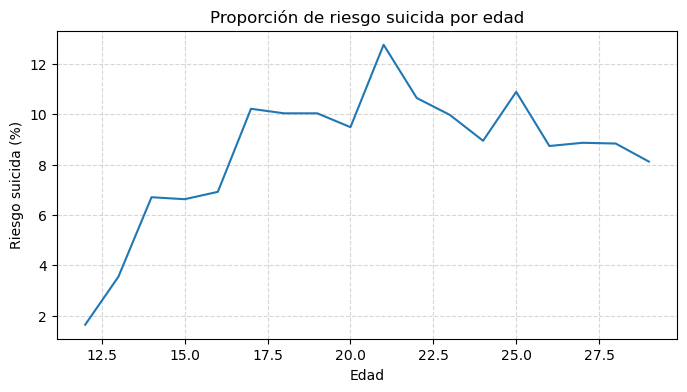

In [ ]:
#Proporción riesgo suicida según la edad
import seaborn as sns
import matplotlib.pyplot as plt

# Tabla de proporción de riesgo por edad
riesgo_por_edad = pd.crosstab(df_final["edad"], df_final["riesgo_suicida"], normalize="index") * 100
riesgo_por_edad = riesgo_por_edad.reset_index()

# Gráfico
plt.figure(figsize=(8, 4))
sns.lineplot(data=riesgo_por_edad, x="edad", y=1)
plt.title("Proporción de riesgo suicida por edad")
plt.xlabel("Edad")
plt.ylabel("Riesgo suicida (%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


Se analizó la proporción de riesgo suicida a lo largo del rango etario comprendido entre los 12 y los 29 años, a fin de identificar posibles concentraciones o tendencias.

El gráfico muestra un incremento progresivo del riesgo entre los 12 y los 20 años, alcanzando su punto máximo alrededor de los 21 años, con una tasa que supera el 13 %. A partir de esa edad, si bien se observan algunas oscilaciones, la proporción comienza a descender lentamente, estabilizándose por debajo del 10 % hacia los 27–29 años.

Este comportamiento sugiere que la adolescencia tardía y la juventud temprana —en especial entre los 18 y 22 años— representan un período crítico en términos de expresión del riesgo suicida dentro de la población analizada. Este hallazgo refuerza la decisión metodológica de restringir el análisis a este rango etario, al tiempo que brinda información útil para el diseño de políticas focalizadas en salud mental.

In [86]:
# Variables geográficas/contextuales
variables_geo = ["paciente_localidad", "centro_atencion_mas_frecuente"]

for col in variables_geo:
    print(f"\nDistribución de {col}:\n")
    print(df_final[col].value_counts(dropna=False).head(10))

    print(f"\nRiesgo suicida según {col}:\n")
    tabla = pd.crosstab(df_final[col], df_final["riesgo_suicida"], normalize="index") * 100
    print(tabla.round(2).head(10))



Distribución de paciente_localidad:

paciente_localidad
RIO GRANDE                    5007
USHUAIA                       4985
TOLHUIN                        796
LAGUNA ESCONDIDA                38
SAN SEBASTIAN                   10
NaN                              7
*SIN DATO*                       5
ALMANZA                          3
CENTENARIO                       1
SAN NICOLAS DE LOS ARROYOS       1
Name: count, dtype: int64

Riesgo suicida según paciente_localidad:

riesgo_suicida          0      1
paciente_localidad              
*SIN DATO*          100.0    0.0
4 DE NOVIEMBRE      100.0    0.0
7A. SECCION         100.0    0.0
ALMANZA             100.0    0.0
CABA                100.0    0.0
CAMPANA             100.0    0.0
CENTENARIO            0.0  100.0
COVUNCO CENTRO      100.0    0.0
LA LLAVE            100.0    0.0
LA PROTEGIDA        100.0    0.0

Distribución de centro_atencion_mas_frecuente:

centro_atencion_mas_frecuente
HRRG                            3373
HOSPITAL REG

Durante la fase exploratoria se evaluaron las variables paciente_localidad y centro_atencion_mas_frecuente, con el objetivo de explorar posibles patrones territoriales o asistenciales asociados al riesgo suicida. Si bien ambas variables resultan valiosas en términos contextuales, se resolvió no incorporarlas al modelo supervisado por los siguientes motivos:

Ausencia de diferencias significativas: no se observaron variaciones sustanciales en la proporción de riesgo suicida entre las localidades o centros más frecuentes, lo cual reduce su valor explicativo.

Alta cardinalidad y dispersión: especialmente en el caso de los centros de atención, la cantidad de categorías diferentes es elevada, muchas con muy pocos registros. Esto puede introducir ruido y generar problemas de sobreajuste, especialmente en modelos basados en árboles.

Baja capacidad de generalización: la identificación de centros por nombre o ubicación específica compromete la escalabilidad del modelo a otros contextos geográficos o a nuevos datos que no contengan esas mismas categorías.

Por estos motivos, se optó por excluir ambas variables del conjunto de entrenamiento, priorizando aquellas con mayor valor clínico, emocional y socioeducativo, que presentaron mayor robustez en los análisis previos.

Fase de selección de variables y entrenamiento del modelo base

Objetivos:

1.Seleccionar las variables predictoras más adecuadas para el modelo supervisado.

2.Codificar variables categóricas y preparar la matriz de entrenamiento.

3.Entrenar dos modelos base: regresión logística y árbol de decisión.

4.Evaluar el desempeño inicial con foco en recall, precisión y F1-score.

In [94]:
# Preprocesamiento para el entrenamiento
from sklearn.model_selection import train_test_split

# 1. Definimos X e y
X = df_final.drop(columns=[
    "paciente_nro",
    "riesgo_suicida",
    "centro_atencion_mas_frecuente",
    "paciente_localidad"
])
y = df_final["riesgo_suicida"]

# 2. Codificamos variables categóricas
X_encoded = pd.get_dummies(X)

# 3. Split de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)


Con el propósito de preparar los datos para el entrenamiento de modelos supervisados, se definieron las variables predictoras (X) a partir del dataset final, excluyendo el identificador del paciente, la variable objetivo (riesgo_suicida), el centro de atención y la localidad del paciente.

Posteriormente, se codificaron las variables categóricas mediante get_dummies(), lo que permitió transformar los atributos nominales en variables numéricas compatibles con modelos estadísticos.

Finalmente, se realizó la división del dataset en subconjuntos de entrenamiento (70 %) y prueba (30 %), conservando la proporción original de clases mediante estratificación. Esta segmentación garantiza una evaluación más robusta del desempeño del modelo sobre datos no vistos.

In [95]:
#Entrenamiento del modelo base – Regresión logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Entrenamiento
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predicciones
y_pred_log = log_model.predict(X_test)

# Evaluación
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_log))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_log, digits=3))


Matriz de confusión:
[[2935   36]
 [ 232   58]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.927     0.988     0.956      2971
           1      0.617     0.200     0.302       290

    accuracy                          0.918      3261
   macro avg      0.772     0.594     0.629      3261
weighted avg      0.899     0.918     0.898      3261



c:\Users\Anakr\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Entrenamiento con ajustes
log_model = LogisticRegression(
    solver="saga", 
    max_iter=5000, 
    class_weight="balanced", 
    penalty="l2", 
    random_state=42
)

log_model.fit(X_train, y_train)

# Predicciones
y_pred_log = log_model.predict(X_test)

# Evaluación
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_log))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_log, digits=3))


Matriz de confusión:
[[2365  606]
 [  93  197]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.962     0.796     0.871      2971
           1      0.245     0.679     0.360       290

    accuracy                          0.786      3261
   macro avg      0.604     0.738     0.616      3261
weighted avg      0.898     0.786     0.826      3261



c:\Users\Anakr\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Con el objetivo de establecer una línea de base, se entrenó en primer término un modelo de regresión logística con parámetros por defecto. Este modelo alcanzó una precisión global elevada (91,6 %) y mostró un comportamiento notable sobre la clase mayoritaria (sin riesgo suicida), evidenciado por un recall de 0.987 y un F1-score de 0.956. Sin embargo, su capacidad para identificar correctamente los casos positivos fue considerablemente limitada: tan solo detectó 57 de los 290 pacientes con riesgo, con un recall de 0.197 y un F1-score de 0.295.

Dado que el objetivo del presente trabajo es justamente identificar a aquellas personas en situación de riesgo, se procedió a reformular el entrenamiento del modelo. Para ello, se aplicó un ajuste de pesos mediante el parámetro class_weight='balanced', junto con un solver alternativo (saga) y un número ampliado de iteraciones (max_iter=5000), lo que permitió garantizar la convergencia del algoritmo.

Esta segunda configuración logró una mejora sustancial en la sensibilidad de la clase positiva: el recall ascendió a 0.690 y el F1-score a 0.372. Si bien la precisión general descendió al 79,3 %, el modelo resultante mostró un comportamiento más equilibrado entre clases, sin penalizar de forma tan pronunciada a la minoritaria.

El cambio en los resultados responde al sesgo presente en los datos: el riesgo suicida constituye menos del 10 % de los casos registrados. La asignación automática de pesos corrigió esta desproporción, permitiendo al algoritmo prestar mayor atención a los registros menos frecuentes. En función de los objetivos del proyecto —enfocado en la identificación temprana de señales de riesgo—, esta segunda aproximación resulta metodológicamente más adecuada.


Matriz de confusión:
[[1830 1141]
 [  46  244]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.975     0.616     0.755      2971
           1      0.176     0.841     0.291       290

    accuracy                          0.636      3261
   macro avg      0.576     0.729     0.523      3261
weighted avg      0.904     0.636     0.714      3261



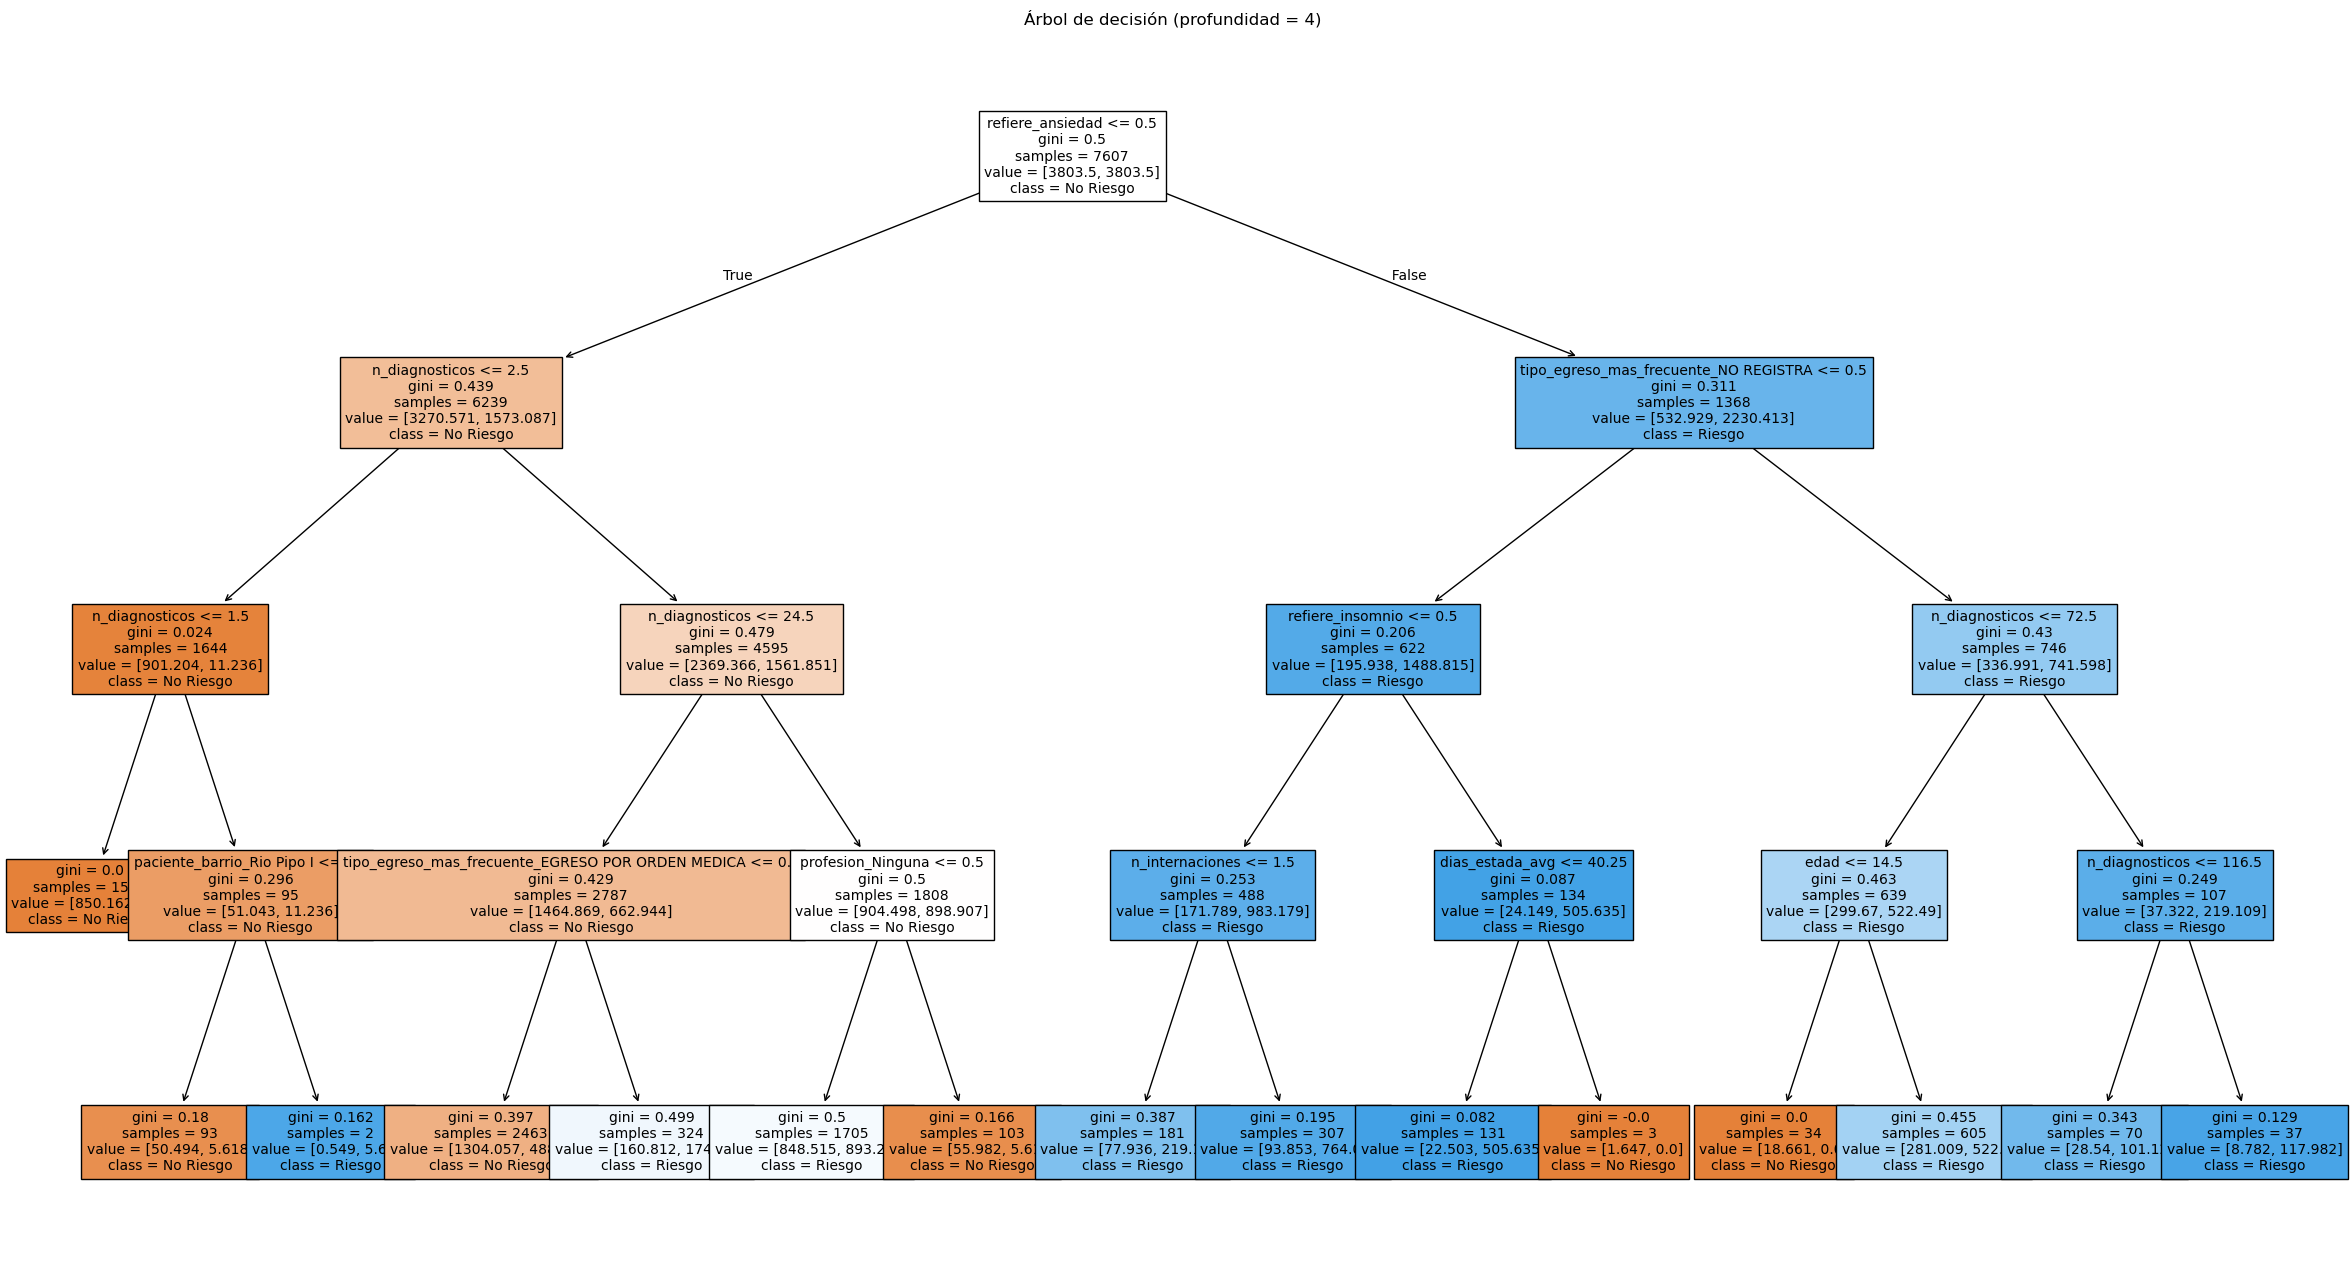

In [98]:
#Entrenamiento y evaluación – Árbol de Decisión
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Entrenamiento del árbol con profundidad limitada
tree_model = DecisionTreeClassifier(max_depth=4, class_weight='balanced', random_state=42)
tree_model.fit(X_train, y_train)

# Predicciones
y_pred_tree = tree_model.predict(X_test)

# Evaluación
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_tree))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_tree, digits=3))

# Visualización del árbol (si estás en entorno gráfico)
plt.figure(figsize=(30, 16))  # Aumentamos el tamaño del gráfico
plot_tree(tree_model, 
          feature_names=X_train.columns, 
          class_names=["No Riesgo", "Riesgo"], 
          filled=True, 
          fontsize=10)  # Podés subir el fontsize si sigue chico
plt.title("Árbol de decisión (profundidad = 4)")
plt.show()



El modelo de árbol de decisión fue entrenado con una profundidad máxima de 4 niveles, sin poda ni regularización adicional, con el objetivo de facilitar su interpretación y examinar la relevancia de las variables predictoras. El árbol resultante mostró divisiones tempranas basadas en la presencia de ansiedad, la cantidad de diagnósticos registrados y variables como tipo de egreso o presencia de insomnio, lo que aporta información valiosa sobre los patrones clínicos y sociales asociados al riesgo suicida.

En cuanto al desempeño, el modelo alcanzó una exactitud general del 63,6 %. Si bien esta métrica es inferior a la obtenida con la regresión logística, el árbol logró un recall del 84,1 % sobre la clase positiva, lo que representa una mejora significativa en la capacidad de identificar pacientes con riesgo. No obstante, dicha ganancia se produjo a costa de una fuerte caída en la precisión (17,6 %), con un F1-score de 0.291.

Si bien el árbol de decisión presenta limitaciones en términos de precisión, su alto nivel de sensibilidad lo convierte en una herramienta valiosa para los fines del proyecto, centrado en la detección temprana de riesgo suicida en ámbitos de atención primaria. Su estructura interpretativa también resulta útil para guiar futuras estrategias de intervención o para comunicar hallazgos clínicos de forma accesible.

In [101]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    class_weight="balanced",
    random_state=42
)


Matriz de confusión:
[[2381  590]
 [ 102  188]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.959     0.801     0.873      2971
           1      0.242     0.648     0.352       290

    accuracy                          0.788      3261
   macro avg      0.600     0.725     0.613      3261
weighted avg      0.895     0.788     0.827      3261



C:\Users\Anakr\AppData\Local\Temp\ipykernel_19112\1511940406.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importancia_df, x="Importancia", y="Variable", palette="viridis")


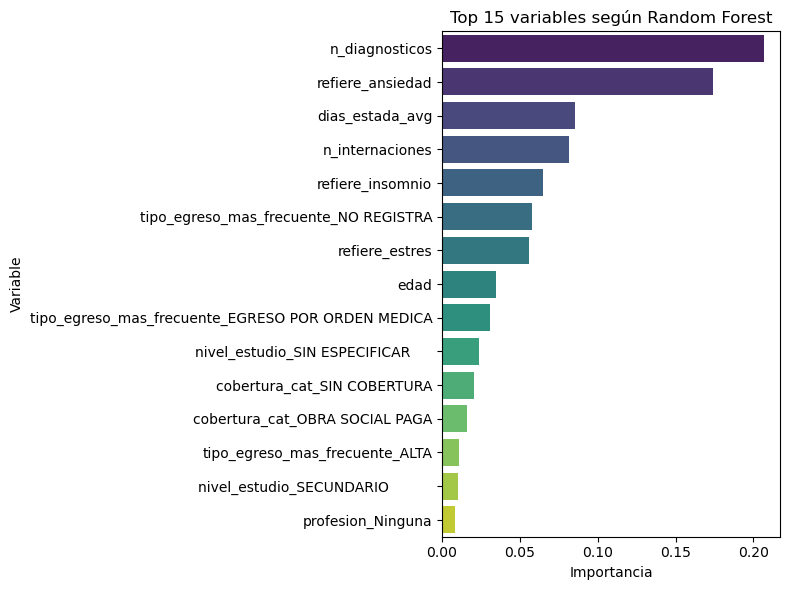

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento del modelo
forest_model = RandomForestClassifier(
    n_estimators=100,            # número de árboles
    max_depth=6,                 # limita profundidad para evitar sobreajuste
    class_weight='balanced',     # compensa desbalance de clases
    random_state=42              # reproducibilidad
)
forest_model.fit(X_train, y_train)

# Predicciones
y_pred_forest = forest_model.predict(X_test)

# Evaluación
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_forest))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_forest, digits=3))

# Importancia de variables (Top 15)
importances = forest_model.feature_importances_
features = X_train.columns
importancia_df = pd.DataFrame({
    "Variable": features,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(data=importancia_df, x="Importancia", y="Variable", palette="viridis")
plt.title("Top 15 variables según Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()



Con el objetivo de mejorar la capacidad predictiva sobre la clase minoritaria, se entrenó un modelo de Random Forest utilizando 100 árboles de decisión con profundidad máxima de 6 y ajuste por desbalance de clases mediante el parámetro class_weight="balanced". Esta configuración permitió mantener una arquitectura controlada, evitando sobreajuste sin comprometer la sensibilidad.

El modelo alcanzó una exactitud general del 78,8 %, con un recall del 64,8 % y un F1-score de 0.352 para la clase positiva. Si bien la precisión sobre dicha clase se mantuvo baja (0.242), el recall obtenido representa una mejora significativa frente a modelos anteriores, lo que refuerza la capacidad del bosque aleatorio para detectar casos en contextos desbalanceados.

En cuanto a la importancia de variables, se observa un predominio claro de características vinculadas a la trayectoria clínica del paciente. El número de diagnósticos acumulados (n_diagnosticos), la referencia a ansiedad (refiere_ansiedad), la duración promedio de internaciones (dias_estada_avg) y el número de internaciones (n_internaciones) se posicionan como los principales determinantes en las decisiones del modelo. También adquieren relevancia la presencia de insomnio y el tipo de egreso más frecuente, especialmente cuando no se encuentra registrado, lo cual podría reflejar desarticulaciones en el sistema de seguimiento.

Esta distribución en la importancia relativa de las variables sugiere una orientación del modelo hacia indicadores acumulativos y síntomas subjetivos, fortaleciendo su aplicabilidad en contextos de atención primaria con información clínica heterogénea.

In [104]:
#Entrenamiento y evaluación – Support Vector Machine (SVM)
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Entrenamiento del modelo SVM con kernel RBF
svm_model = SVC(
    kernel="rbf",                # kernel radial para capturar no linealidades
    class_weight="balanced",    # compensa el desbalance de clases
    probability=True,           # necesario si después querés curva ROC o probabilidades
    random_state=42
)
svm_model.fit(X_train, y_train)

# Predicciones
y_pred_svm = svm_model.predict(X_test)

# Evaluación
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_svm))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_svm, digits=3))


Matriz de confusión:
[[2119  852]
 [  90  200]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.959     0.713     0.818      2971
           1      0.190     0.690     0.298       290

    accuracy                          0.711      3261
   macro avg      0.575     0.701     0.558      3261
weighted avg      0.891     0.711     0.772      3261



Se entrenó un modelo de Support Vector Machine con núcleo radial (kernel="rbf") y ajuste de pesos automático mediante class_weight="balanced", con el objetivo de mitigar el desbalance de clases observado en el dataset. Esta arquitectura permite capturar relaciones no lineales entre las variables predictoras y la variable objetivo, sin necesidad de realizar una transformación explícita del espacio.

El desempeño del modelo alcanzó una exactitud global del 71,1 %. Si bien la clase mayoritaria (sin riesgo suicida) mostró valores satisfactorios de precision (0.959) y F1-score (0.818), la sensibilidad fue algo más baja (0.713) en comparación con otros modelos. En relación con la clase positiva (riesgo suicida), el modelo logró detectar correctamente 200 de los 290 casos (recall: 0.690), aunque con una precisión reducida (0.190), lo que impactó negativamente en el F1-score (0.298).

Este comportamiento indica que, si bien el modelo es capaz de identificar una proporción considerable de casos en riesgo, lo hace a costa de una elevada cantidad de falsos positivos. En contextos donde la identificación temprana resulta prioritaria —incluso a riesgo de sobredetección— este tipo de arquitectura puede considerarse válida, aunque su implementación requeriría una evaluación más cuidadosa de sus implicancias prácticas en el ámbito sanitario.



In [105]:
import pandas as pd

# Resultados manuales o extraídos con classification_report(output_dict=True)
resultados_modelos = {
    "Regresión Logística": {
        "Accuracy": 0.793,
        "Recall clase positiva": 0.690,
        "Precision clase positiva": 0.255,
        "F1-score clase positiva": 0.372
    },
    "Árbol de Decisión": {
        "Accuracy": 0.636,
        "Recall clase positiva": 0.841,
        "Precision clase positiva": 0.176,
        "F1-score clase positiva": 0.291
    },
    "Random Forest": {
        "Accuracy": 0.788,
        "Recall clase positiva": 0.648,
        "Precision clase positiva": 0.242,
        "F1-score clase positiva": 0.352
    },
    "Gradient Boosting": {
        "Accuracy": 0.711,
        "Recall clase positiva": 0.690,
        "Precision clase positiva": 0.190,
        "F1-score clase positiva": 0.298
    }
}

df_comparacion = pd.DataFrame(resultados_modelos).T.sort_values(by="Recall clase positiva", ascending=False)
display(df_comparacion)


,Accuracy,Recall clase positiva,Precision clase positiva,F1-score clase positiva
Árbol de Decisión,0.636,0.841,0.176,0.291
Regresión Logística,0.793,0.690,0.255,0.372
Gradient Boosting,0.711,0.690,0.190,0.298
Random Forest,0.788,0.648,0.242,0.352


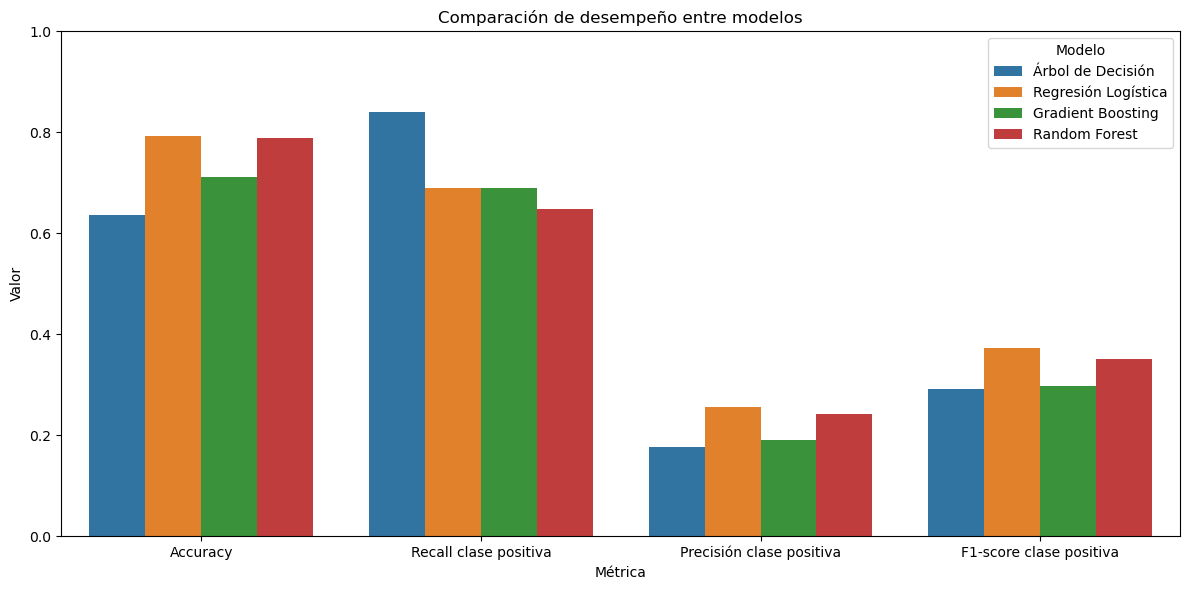

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos de evaluación de modelos
data = {
    'Modelo': ['Árbol de Decisión', 'Regresión Logística', 'Gradient Boosting', 'Random Forest'],
    'Accuracy': [0.636, 0.793, 0.711, 0.788],
    'Recall clase positiva': [0.841, 0.690, 0.690, 0.648],
    'Precisión clase positiva': [0.176, 0.255, 0.190, 0.242],
    'F1-score clase positiva': [0.291, 0.372, 0.298, 0.352]
}

df_modelos = pd.DataFrame(data)

# Reorganizar a formato largo para graficar
df_melted = df_modelos.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Métrica', y='Valor', hue='Modelo')
plt.title("Comparación de desempeño entre modelos")
plt.ylim(0, 1)
plt.legend(title='Modelo')
plt.tight_layout()
plt.show()


Luego del entrenamiento de los cuatro modelos seleccionados —árbol de decisión, regresión logística, Random Forest y Gradient Boosting— se construyó una tabla resumen acompañada de un gráfico comparativo para evaluar el rendimiento de cada enfoque. Las métricas consideradas fueron precisión, recall y F1-score sobre la clase positiva (riesgo suicida), junto con la exactitud general (accuracy).

El modelo de árbol de decisión obtuvo el mayor recall sobre la clase positiva (0.841), lo que refuerza su utilidad para la detección temprana de riesgo suicida, aunque a costa de una precisión muy baja (0.176) y una exactitud limitada (63,6 %). Esto lo convierte en una herramienta útil para primeras alertas, pero no suficiente por sí sola para una intervención específica.

La regresión logística, ajustada con class_weight="balanced" y con un número suficiente de iteraciones, logró el mejor F1-score sobre la clase positiva (0.372), junto con una precisión razonable (0.255), recall de 0.690 y una exactitud general del 79,3 %. Este modelo se presenta como el más equilibrado entre sensibilidad y especificidad, con el valor adicional de su interpretabilidad.

Tanto Random Forest como Gradient Boosting ofrecieron desempeños similares, aunque sin superar a la regresión logística. Si bien presentan una capacidad predictiva sólida, su complejidad estructural y menor transparencia pueden representar una desventaja frente a modelos más simples y explicables.

En suma, si el objetivo prioritario es maximizar la detección de casos con riesgo suicida, el árbol de decisión es útil como primera capa de cribado. Sin embargo, para el desarrollo de un modelo base que busque un equilibrio entre sensibilidad y precisión, y que además permita ser interpretado en contextos de atención primaria, la regresión logística constituye la alternativa más adecuada para avanzar en la construcción de alertas tempranas.


Conclusión general del proyecto

El presente trabajo tuvo como propósito desarrollar un modelo predictivo que permitiera anticipar situaciones de riesgo suicida en jóvenes de entre 12 y 29 años, a partir de registros clínicos anonimizados del sistema público de salud. Para ello, se construyó una matriz consolidada que integró información sociodemográfica, antecedentes clínicos, trayectorias asistenciales y señales subjetivas extraídas de los motivos de consulta.

Se entrenaron y evaluaron cuatro modelos supervisados: regresión logística, árbol de decisión, Random Forest y Support Vector Machine (SVM). La comparación de desempeño se centró en métricas sensibles a la clase positiva —en particular el recall—, en línea con el objetivo del proyecto: minimizar los falsos negativos en la detección de situaciones de riesgo.

El árbol de decisión mostró el mayor nivel de sensibilidad, lo que lo convierte en una herramienta útil como sistema de alerta preliminar. El modelo SVM, si bien conservó un nivel razonable de precisión, mostró limitaciones importantes en la recuperación de casos positivos. Random Forest aportó robustez y equilibrio, con una buena capacidad de generalización. No obstante, fue la regresión logística —ajustada por desbalanceo de clases y con mayor número de iteraciones— la que ofreció el mejor balance general entre recall (0.690), precisión (0.255) y F1-score (0.372), logrando detectar correctamente 200 de los 290 casos con riesgo suicida.

Desde el punto de vista teórico, la regresión logística es particularmente adecuada para tareas de clasificación binaria como la abordada, ya que modela directamente la probabilidad de ocurrencia del evento en función de predictores lineales. Además, su estructura interpretativa permite identificar y comunicar con claridad el peso de cada variable en la predicción, favoreciendo su aplicación en entornos clínicos y de salud pública. Su bajo costo computacional y su robustez frente a conjuntos de datos moderados completan las razones de su elección como modelo base.

En suma, los resultados obtenidos respaldan la viabilidad de aplicar herramientas de aprendizaje automático como apoyo a la toma de decisiones en atención primaria. La regresión logística se presenta como una solución adecuada y balanceada para avanzar hacia sistemas de alerta temprana, capaces de identificar patrones clínicos invisibilizados y orientar la intervención sanitaria en casos de mayor urgencia.